In [ ]:
import scipy.stats as stats
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import statsmodels.api as sm
from statsmodels.stats.sandwich_covariance import cov_hac
warnings.filterwarnings("ignore", category=DeprecationWarning)
from google.colab import files
from sklearn.metrics import (roc_auc_score, log_loss, f1_score, precision_recall_curve, auc)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report


In [ ]:
upload = files.upload()

Saving regime_data.csv to regime_data.csv


In [ ]:
df=pd.read_csv("regime_data.csv")
df['Date']= pd.to_datetime(df['Date'])
df = df.set_index('Date')
df = df.drop('RV', axis=1)
df = df.rename(columns={'IV': 'VIX'})
df = df.rename(columns={'SKEW': 'IVS'})
df.head()

,VIX,VRP,IVS
Date,,,
1990-01-02,0.1724,0.013732,126.09
1990-01-03,0.1819,0.017098,123.34
1990-01-04,0.1922,0.020951,122.62
1990-01-05,0.2011,0.024846,121.27
1990-01-08,0.2026,0.026346,124.12


In [ ]:
## Continous Regression--daily

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

results = []
daily_data=df.copy()

for col in ['VIX', 'VRP','IVS']:
  for lag in range(23, 46):
      daily_data[f'{col}_lag_{lag}'] = daily_data[col].shift(lag)

daily_data.reset_index(inplace=True)

train_idx, test_idx = train_test_split(daily_data.index, test_size=0.2, shuffle=False)


for max_lag in range(23, 46):  # Lag 23 to 45
    # Create list of features for all lags up to max_lag
    cols = []
    for lag in range(23, max_lag + 1):
        for var in ['VIX', 'IVS', 'VRP']:
            cols.append(f'{var}_lag_{lag}')

    # Define X and y
    X = daily_data[cols]
    y = daily_data['VIX']

    # Clean and align
    X = sm.add_constant(X)
    X, y = X.align(y, join='inner', axis=0)

    # Train/Test split using the pre-defined index
    X_train, X_test = X.loc[train_idx], X.loc[test_idx]
    y_train, y_test = y.loc[train_idx], y.loc[test_idx]

    # Combine and drop any NaNs/Infs
    train_df = pd.concat([X_train, y_train], axis=1)
    train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    train_df.dropna(inplace=True)

    # Split them back
    X_train = train_df.drop(columns=y_train.name)
    y_train = train_df[y_train.name]

    # Fit OLS model
    model = sm.OLS(y_train, X_train).fit()

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Store summary stats
    results.append({
    'max_lag': max_lag,
    'r2_in_sample': r2_score(y_train, y_pred_train),
    'r2_out_of_sample': r2_score(y_test, y_pred_test),
    'mse_in_sample': mean_squared_error(y_train, y_pred_train),
    'mse_out_of_sample': mean_squared_error(y_test, y_pred_test),
    'aic': model.aic,
    'bic': model.bic
      })

# Convert to DataFrame to view results
results_df = pd.DataFrame(results)
#print(results_df)
results_df

,max_lag,r2_in_sample,r2_out_of_sample,mse_in_sample,mse_out_of_sample,aic,bic
0,23,0.651141,0.200659,0.002165,0.004650,-23328.017195,-23300.558774
1,24,0.653776,0.196717,0.002149,0.004673,-23371.768855,-23323.717607
2,25,0.655200,0.191129,0.002140,0.004706,-23391.063561,-23322.420334
3,26,0.655835,0.189346,0.002136,0.004716,-23394.264524,-23305.030166
4,27,0.656481,0.187384,0.002133,0.004727,-23397.629927,-23287.805287
5,28,0.657015,0.186226,0.002129,0.004734,-23398.647130,-23268.233056
6,29,0.657265,0.185733,0.002128,0.004737,-23393.795909,-23242.793250
7,30,0.657456,0.184360,0.002127,0.004745,-23387.819157,-23216.228763
8,31,0.657652,0.183294,0.002126,0.004751,-23381.871323,-23189.694043
9,32,0.657977,0.181864,0.002124,0.004760,-23378.380981,-23165.617663


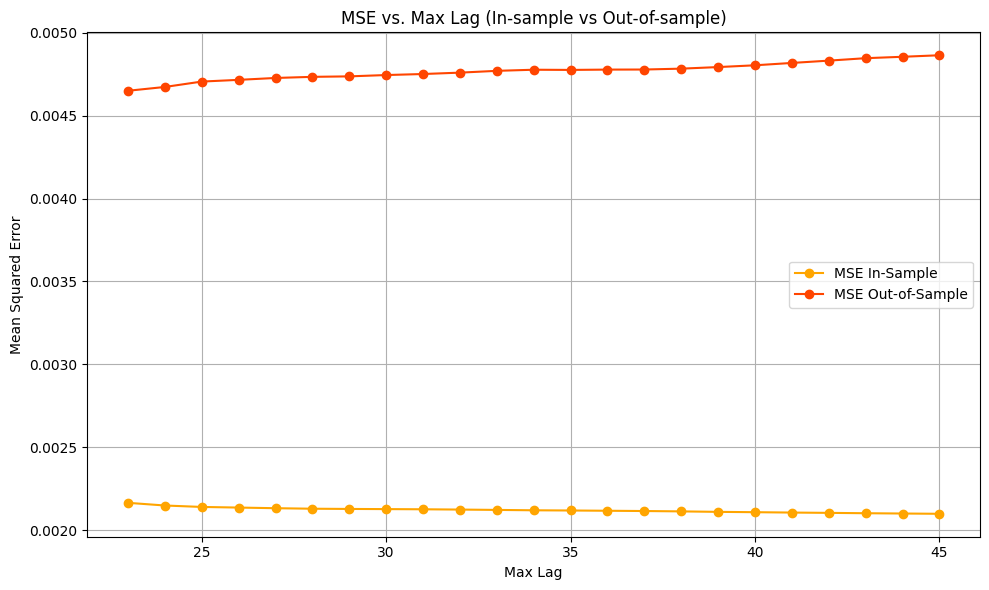

In [ ]:
plt.figure(figsize=(10, 6))

# Plot in-sample MSE
plt.plot(results_df['max_lag'], results_df['mse_in_sample'],
         label='MSE In-Sample', marker='o', color='orange')

# Plot out-of-sample MSE
plt.plot(results_df['max_lag'], results_df['mse_out_of_sample'],
         label='MSE Out-of-Sample', marker='o', color='orangered')

# Labels and title
plt.xlabel('Max Lag')
plt.ylabel('Mean Squared Error')
plt.title('MSE vs. Max Lag (In-sample vs Out-of-sample)')
plt.legend()
plt.grid(True)
plt.tight_layout()

In [ ]:
## Continous Regression--daily+threshold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score

results = []
daily_data=df.copy()

for col in ['VIX', 'VRP','IVS']:
  for lag in range(23, 46):
      daily_data[f'{col}_lag_{lag}'] = daily_data[col].shift(lag)

daily_data.reset_index(inplace=True)

train_idx, test_idx = train_test_split(daily_data.index, test_size=0.2, shuffle=False)

daily_back=daily_data.copy()

for max_lag in range(23, 46):  # Lag 23 to 44
    # Create list of features for all lags up to max_lag
    cols = []
    for lag in range(23, max_lag + 1):
        for var in ['VIX', 'IVS', 'VRP']:
            cols.append(f'{var}_lag_{lag}')
    daily_data=daily_back.copy()
    # Define X and y
    X = daily_data[cols]
    y = daily_data['VIX']

    # Clean and align
    X = sm.add_constant(X)
    X, y = X.align(y, join='inner', axis=0)

    # Train/Test split using the pre-defined index
    print (X.index)
    X_train, X_test = X.loc[train_idx], X.loc[test_idx]
    y_train, y_test = y.loc[train_idx], y.loc[test_idx]

    # Combine and drop any NaNs/Infs
    train_df = pd.concat([X_train, y_train], axis=1)
    train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    train_df.dropna(inplace=True)

    # Split them back
    X_train = train_df.drop(columns=y_train.name)
    y_train = train_df[y_train.name]

    # Fit OLS model
    model = sm.OLS(y_train, X_train).fit()
    daily_data.dropna(inplace=True)

    rolling_mean = daily_data['VIX'].rolling(window=2520).mean()
    rolling_std = daily_data['VIX'].rolling(window=2520).std()
    daily_data['VIX_threshold'] = rolling_mean + rolling_std
    daily_data.dropna(inplace=True)

    daily_data['y_pred_train'] = model.predict(X_train)
    daily_data['y_pred_test'] = model.predict(X_test)


    daily_data['target'] = (daily_data['VIX'] > daily_data['VIX_threshold']).astype(int)
    daily_data['trained_target']=(daily_data['y_pred_train'] > daily_data['VIX_threshold']).astype(int)
    daily_data['test_target']=(daily_data['y_pred_test'] > daily_data['VIX_threshold']).astype(int)

    overlap_trained = daily_data.index.intersection(train_idx)
    overlap_test = daily_data.index.intersection(test_idx)



    # Store summary stats
    results.append({
    'max_lag': max_lag,
    'f1_score_train': f1_score( daily_data['target'].loc[overlap_trained] , daily_data['trained_target'].loc[overlap_trained]),
    'f1_score_test': f1_score( daily_data['target'].loc[overlap_test] , daily_data['test_target'].loc[overlap_test]),
    'accuracy_train': accuracy_score( daily_data['target'].loc[overlap_trained] , daily_data['trained_target'].loc[overlap_trained]),
    'accuracy_test': accuracy_score( daily_data['target'].loc[overlap_test] , daily_data['test_target'].loc[overlap_test])
      })


# Convert to DataFrame to view results
results_df = pd.DataFrame(results)
print(results_df)



RangeIndex(start=0, stop=8875, step=1)
RangeIndex(start=0, stop=8875, step=1)
RangeIndex(start=0, stop=8875, step=1)
RangeIndex(start=0, stop=8875, step=1)
RangeIndex(start=0, stop=8875, step=1)
RangeIndex(start=0, stop=8875, step=1)
RangeIndex(start=0, stop=8875, step=1)
RangeIndex(start=0, stop=8875, step=1)
RangeIndex(start=0, stop=8875, step=1)
RangeIndex(start=0, stop=8875, step=1)
RangeIndex(start=0, stop=8875, step=1)
RangeIndex(start=0, stop=8875, step=1)
RangeIndex(start=0, stop=8875, step=1)
RangeIndex(start=0, stop=8875, step=1)
RangeIndex(start=0, stop=8875, step=1)
RangeIndex(start=0, stop=8875, step=1)
RangeIndex(start=0, stop=8875, step=1)
RangeIndex(start=0, stop=8875, step=1)
RangeIndex(start=0, stop=8875, step=1)
RangeIndex(start=0, stop=8875, step=1)
RangeIndex(start=0, stop=8875, step=1)
RangeIndex(start=0, stop=8875, step=1)
RangeIndex(start=0, stop=8875, step=1)
    max_lag  f1_score_train  f1_score_test  accuracy_train  accuracy_test
0        23        0.623600  

In [ ]:
## Continous Regression--monthly

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

results = []
daily_data=df.copy()
monthly_data = daily_data.resample('ME').mean()
monthly_data = monthly_data.dropna()
monthly_data.reset_index(inplace=True)


for col in ['VIX', 'VRP','IVS']:
  for lag in range(1, 8):
      monthly_data[f'{col}_lag_{lag}'] = monthly_data[col].shift(lag)

train_idx, test_idx = train_test_split(monthly_data.index, test_size=0.2, shuffle=False)

for max_lag in range(1, 8):  # Lag 23 to 44
    # Create list of features for all lags up to max_lag
    cols = []
    for lag in range(1, max_lag + 1):
        for var in ['VIX', 'IVS', 'VRP']:
            cols.append(f'{var}_lag_{lag}')

    # Define X and y
    X = monthly_data[cols]
    y = monthly_data['VIX']

    # Clean and align
    X = sm.add_constant(X)
    X, y = X.align(y, join='inner', axis=0)


    # Train/Test split using the pre-defined index
    X_train, X_test = X.loc[train_idx], X.loc[test_idx]
    y_train, y_test = y.loc[train_idx], y.loc[test_idx]

    # Combine and drop any NaNs/Infs
    train_df = pd.concat([X_train, y_train], axis=1)
    train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    train_df.dropna(inplace=True)

    # Split them back
    X_train = train_df.drop(columns=y_train.name)
    y_train = train_df[y_train.name]

    # Fit OLS model
    model = sm.OLS(y_train, X_train).fit()

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Store summary stats
    results.append({
    'max_lag': max_lag,
    'r2_in_sample': r2_score(y_train, y_pred_train),
    'r2_out_of_sample': r2_score(y_test, y_pred_test),
    'mse_in_sample': mean_squared_error(y_train, y_pred_train),
    'mse_out_of_sample': mean_squared_error(y_test, y_pred_test),
    'aic': model.aic,
    'bic': model.bic
      })

# Convert to DataFrame to view results
results_df = pd.DataFrame(results)
#print(results_df)
results_df


,max_lag,r2_in_sample,r2_out_of_sample,mse_in_sample,mse_out_of_sample,aic,bic
0,1,0.794030,0.378508,0.001190,0.002961,-1301.156229,-1285.887784
1,2,0.802420,0.352834,0.001144,0.003083,-1304.457710,-1277.758796
2,3,0.808814,0.340905,0.001110,0.003140,-1304.521085,-1266.409675
3,4,0.810337,0.323416,0.001104,0.003223,-1296.294239,-1246.788386
4,5,0.812160,0.323268,0.001097,0.003224,-1288.557210,-1227.675050
5,6,0.813011,0.313869,0.001095,0.003269,-1279.192497,-1206.952248
6,7,0.816275,0.305190,0.001079,0.003310,-1274.040389,-1190.460351


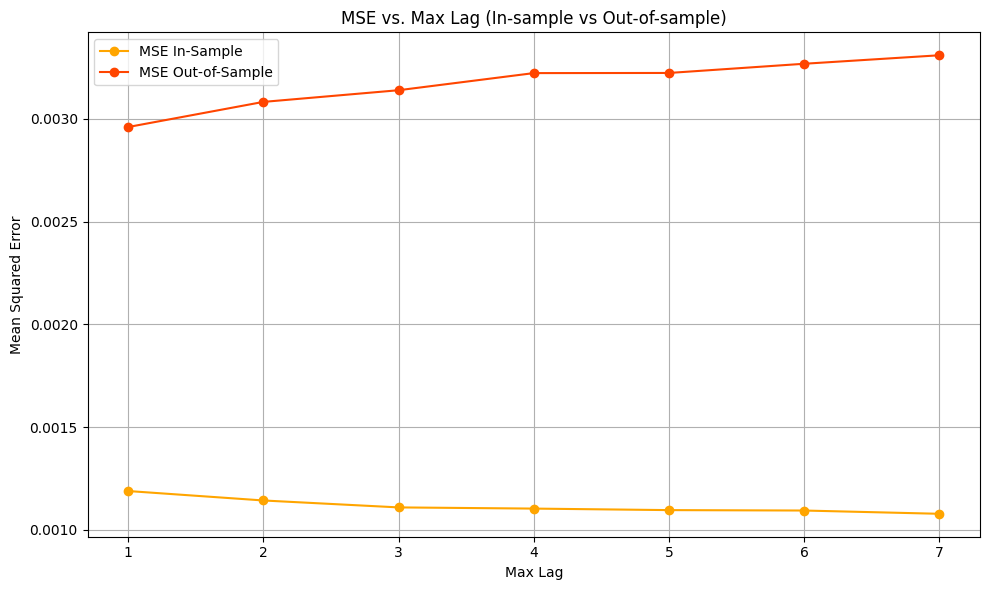

In [ ]:
plt.figure(figsize=(10, 6))

# Plot in-sample MSE
plt.plot(results_df['max_lag'], results_df['mse_in_sample'],
         label='MSE In-Sample', marker='o', color='orange')

# Plot out-of-sample MSE
plt.plot(results_df['max_lag'], results_df['mse_out_of_sample'],
         label='MSE Out-of-Sample', marker='o', color='orangered')

# Labels and title
plt.xlabel('Max Lag')
plt.ylabel('Mean Squared Error')
plt.title('MSE vs. Max Lag (In-sample vs Out-of-sample)')
plt.legend()
plt.grid(True)
plt.tight_layout()

Continuous monthly-threshold

In [ ]:
monthly_data=df.copy()
rolling_mean = monthly_data['VIX'].rolling(window=2520).mean()
rolling_std = monthly_data['VIX'].rolling(window=2520).std()
monthly_data['VIX_threshold'] = rolling_mean + rolling_std
monthly_data = monthly_data.resample('ME').mean()
monthly_data['target'] = (monthly_data['VIX'] > monthly_data['VIX_threshold']).astype(int)
monthly_data_threshold=monthly_data[['target','VIX_threshold']]
monthly_data_threshold.reset_index(inplace=True)

In [ ]:
## Continous Regression--monthly-threshold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score


monthly_data=df.copy()
monthly_data = monthly_data.resample('ME').mean()
for col in ['VIX', 'VRP','IVS']:
  for lag in range(1, 8):
      monthly_data[f'{col}_lag_{lag}'] = monthly_data[col].shift(lag)

monthly_back=monthly_data.copy()

results = []
monthly_data.reset_index(inplace=True)
train_idx, test_idx = train_test_split(monthly_data.index, test_size=0.2, shuffle=False)

for max_lag in range(1, 8):  # Lag
    # Create list of features for all lags up to max_lag
    cols = []
    for lag in range(1, max_lag + 1):
        for var in ['VIX', 'IVS', 'VRP']:
            cols.append(f'{var}_lag_{lag}')


    monthly_data=monthly_back.copy()
    monthly_data.reset_index(inplace=True)

    # Define X and y
    X = monthly_data[cols]
    y = monthly_data['VIX']

    X = sm.add_constant(X)
    X, y = X.align(y, join='inner', axis=0)

    # Train/Test split using the pre-defined index
    X_train, X_test = X.loc[train_idx], X.loc[test_idx]
    y_train, y_test = y.loc[train_idx], y.loc[test_idx]

    # Combine and drop any NaNs/Infs
    train_df = pd.concat([X_train, y_train], axis=1)
    train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    train_df.dropna(inplace=True)

    # Split them back
    X_train = train_df.drop(columns=y_train.name)
    y_train = train_df[y_train.name]

    # Fit OLS model
    model = sm.OLS(y_train, X_train).fit()
    monthly_data.dropna(inplace=True)

    # merge target + initial results
    monthly_data= pd.merge(monthly_data, monthly_data_threshold[['Date','target','VIX_threshold']], on='Date', how='left')
    monthly_data.dropna(inplace=True)



    monthly_data['y_pred_train'] = model.predict(X_train)
    monthly_data['y_pred_test'] = model.predict(X_test)


    monthly_data['target'] = (monthly_data['VIX'] > monthly_data['VIX_threshold']).astype(int)
    monthly_data['trained_target']=(monthly_data['y_pred_train'] > monthly_data['VIX_threshold']).astype(int)
    monthly_data['test_target']=(monthly_data['y_pred_test'] > monthly_data['VIX_threshold']).astype(int)

    overlap_trained = monthly_data.index.intersection(train_idx)
    overlap_test = monthly_data.index.intersection(test_idx)

# Store summary stats
    results.append({
    'max_lag': max_lag,
    'f1_score_train': f1_score( monthly_data['target'].loc[overlap_trained] , monthly_data['trained_target'].loc[overlap_trained]),
    'f1_score_test': f1_score( monthly_data['target'].loc[overlap_test] , monthly_data['test_target'].loc[overlap_test]),
    'accuracy_train': accuracy_score( monthly_data['target'].loc[overlap_trained] , monthly_data['trained_target'].loc[overlap_trained]),
    'accuracy_test': accuracy_score( monthly_data['target'].loc[overlap_test] , monthly_data['test_target'].loc[overlap_test])
      })

# Convert to DataFrame to view results
results_df = pd.DataFrame(results)
#print(results_df)

results_df

,max_lag,f1_score_train,f1_score_test,accuracy_train,accuracy_test
0,1,0.140351,0.071429,0.782222,0.666667
1,2,0.135593,0.068966,0.773333,0.653846
2,3,0.193548,0.071429,0.777778,0.666667
3,4,0.193548,0.071429,0.777778,0.666667
4,5,0.172414,0.074074,0.786667,0.679487
5,6,0.200000,0.071429,0.786667,0.666667
6,7,0.190476,0.066667,0.773333,0.641026


In [ ]:
df_logistic=df.copy()
rolling_mean = df_logistic['VIX'].rolling(window=2520).mean()
rolling_std = df_logistic['VIX'].rolling(window=2520).std()
df_logistic['VIX_threshold'] = rolling_mean + rolling_std
df_logistic['target'] = (df_logistic['VIX'] > df_logistic['VIX_threshold']).astype(int)
df_logistic

,VIX,VRP,IVS,VIX_threshold,target
Date,,,,,
1990-01-02,0.1724,0.013732,126.09,NaN,0
1990-01-03,0.1819,0.017098,123.34,NaN,0
1990-01-04,0.1922,0.020951,122.62,NaN,0
1990-01-05,0.2011,0.024846,121.27,NaN,0
1990-01-08,0.2026,0.026346,124.12,NaN,0
...,...,...,...,...,...
2025-02-24,0.1898,0.027092,156.93,0.255568,0
2025-02-25,0.1943,0.028958,157.60,0.255586,0
2025-02-26,0.1910,0.027686,153.44,0.255602,0


In [ ]:
# logicstic _daily
results=[]
from sklearn.metrics import (
    roc_auc_score, log_loss, f1_score, precision_recall_curve, auc
)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report


df_logistic_daily=df_logistic.copy()
df_logistic_daily.reset_index(inplace=True)
for col in ['VIX', 'VRP','IVS']:
  for lag in range(23, 46):
      df_logistic_daily[f'{col}_lag_{lag}'] = df_logistic_daily[col].shift(lag)

df_logistic_daily.dropna(inplace=True)


train_idx, test_idx = train_test_split(df_logistic_daily.index, test_size=0.2, shuffle=False)

for max_lag in range(23, 46):  # Lag 23 to 44
    # Create list of features for all lags up to max_lag
    cols = []
    for lag in range(23, max_lag + 1):
        for var in ['VIX', 'IVS', 'VRP']:
            cols.append(f'{var}_lag_{lag}')

    # Define X and y
    X = df_logistic_daily[cols]
    y = df_logistic_daily['target']

    X, y = X.align(y, join='inner', axis=0)

    # Train/Test split using the pre-defined index
    X_train, X_test = X.loc[train_idx], X.loc[test_idx]
    y_train, y_test = y.loc[train_idx], y.loc[test_idx]


    model = LogisticRegression(max_iter=5000)
    model.fit(X_train, y_train)

    train_probs = model.predict_proba(X_train)[:, 1]
    test_probs = model.predict_proba(X_test)[:, 1]
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)

    # Precision-recall AUC
    precision_train, recall_train, _ = precision_recall_curve(y_train, train_probs)
    pr_auc_train = auc(recall_train, precision_train)

    precision_test, recall_test, _ = precision_recall_curve(y_test, test_probs)
    pr_auc_test = auc(recall_test, precision_test)

    # Store results
    results.append({
        'max_lag': max_lag,
        'roc_auc_train': roc_auc_score(y_train, train_probs),
        'roc_auc_test': roc_auc_score(y_test, test_probs),
        'log_loss_train': log_loss(y_train, train_probs),
        'log_loss_test': log_loss(y_test, test_probs),
        'f1_score_train': f1_score(y_train, train_preds),
        'f1_score_test': f1_score(y_test, test_preds),
         'accuracy_train': accuracy_score(y_train, train_preds),
         'accuracy_test': accuracy_score(y_test, test_preds),
        'pr_auc_train': pr_auc_train,
        'pr_auc_test': pr_auc_test
    })


In [ ]:
results_df = pd.DataFrame(results)
results_df

,max_lag,roc_auc_train,roc_auc_test,log_loss_train,log_loss_test,f1_score_train,f1_score_test,accuracy_train,accuracy_test,pr_auc_train,pr_auc_test
0,23,0.892909,0.785568,0.250246,0.758761,0.490375,0.167630,0.901062,0.773585,0.665110,0.547432
1,24,0.893957,0.789512,0.245868,0.752891,0.519024,0.193732,0.903029,0.777516,0.671630,0.556682
2,25,0.894023,0.790966,0.244652,0.748191,0.524590,0.188571,0.903029,0.776730,0.673311,0.559625
3,26,0.893684,0.789638,0.244421,0.752830,0.521073,0.198864,0.901652,0.778302,0.673255,0.557855
4,27,0.893479,0.789159,0.244094,0.757319,0.522814,0.198864,0.901259,0.778302,0.674369,0.555036
5,28,0.893391,0.787382,0.243877,0.763885,0.524621,0.198864,0.901259,0.778302,0.674956,0.551384
6,29,0.893305,0.785261,0.243775,0.769950,0.530303,0.193732,0.902439,0.777516,0.675003,0.547807
7,30,0.893550,0.782787,0.243530,0.776573,0.531693,0.193732,0.902636,0.777516,0.675017,0.542660
8,31,0.893944,0.781069,0.243215,0.780721,0.534337,0.198864,0.902636,0.778302,0.675250,0.539510
9,32,0.894361,0.778618,0.243074,0.792879,0.536585,0.198864,0.902832,0.778302,0.675266,0.534216


In [ ]:
df_logistic_monthly=df.copy()
rolling_mean = df_logistic_monthly['VIX'].rolling(window=2520).mean()
rolling_std = df_logistic_monthly['VIX'].rolling(window=2520).std()
df_logistic_monthly['VIX_threshold'] = rolling_mean + rolling_std
df_logistic_monthly = df_logistic_monthly.resample('ME').mean()

df_logistic_monthly['target'] = (df_logistic_monthly['VIX'] > df_logistic_monthly['VIX_threshold']).astype(int)
df_logistic_monthly


,VIX,VRP,IVS,VIX_threshold,target
Date,,,,,
1990-01-31,0.233473,0.041404,122.230000,NaN,0
1990-02-28,0.232626,0.022906,128.244211,NaN,0
1990-03-31,0.200623,-0.006661,128.966818,NaN,0
1990-04-30,0.214035,0.034661,120.088500,NaN,0
1990-05-31,0.180977,0.013929,120.250455,NaN,0
...,...,...,...,...,...
2024-10-31,0.199609,0.032092,154.811739,0.255438,0
2024-11-30,0.160152,0.018226,153.442381,0.255727,0
2024-12-31,0.158662,-0.007370,168.840476,0.255578,0


In [ ]:
# logicstic _monthly
results=[]
from sklearn.metrics import (
    roc_auc_score, log_loss, f1_score, precision_recall_curve, auc
)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report




for col in ['VIX', 'VRP','IVS']:
  for lag in range(1, 10):
      df_logistic_monthly[f'{col}_lag_{lag}'] = df_logistic_monthly[col].shift(lag)

df_logistic_monthly.dropna(inplace=True)
df_logistic_monthly.reset_index(inplace=True)

train_idx, test_idx = train_test_split(df_logistic_monthly.index, test_size=0.2, shuffle=False)

for max_lag in range(1, 8):  # Lag 23 to 44
    # Create list of features for all lags up to max_lag
    cols = []
    for lag in range(1, max_lag + 1):
        for var in ['VIX', 'IVS', 'VRP']:
            cols.append(f'{var}_lag_{lag}')

    # Define X and y
    X = df_logistic_monthly[cols]
    y = df_logistic_monthly['target']

    X, y = X.align(y, join='inner', axis=0)

    # Train/Test split using the pre-defined index
    X_train, X_test = X.loc[train_idx], X.loc[test_idx]
    y_train, y_test = y.loc[train_idx], y.loc[test_idx]


    model = LogisticRegression(max_iter=5000)
    model.fit(X_train, y_train)

    train_probs = model.predict_proba(X_train)[:, 1]
    test_probs = model.predict_proba(X_test)[:, 1]
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)

    # Precision-recall AUC
    precision_train, recall_train, _ = precision_recall_curve(y_train, train_probs)
    pr_auc_train = auc(recall_train, precision_train)

    precision_test, recall_test, _ = precision_recall_curve(y_test, test_probs)
    pr_auc_test = auc(recall_test, precision_test)

    # Store results
    results.append({
        'max_lag': max_lag,
        'roc_auc_train': roc_auc_score(y_train, train_probs),
        'roc_auc_test': roc_auc_score(y_test, test_probs),
        'log_loss_train': log_loss(y_train, train_probs),
        'log_loss_test': log_loss(y_test, test_probs),
        'f1_score_train': f1_score(y_train, train_preds),
        'f1_score_test': f1_score(y_test, test_preds),
        'accuracy_train': accuracy_score( y_train, train_preds),
         'accuracy_test': accuracy_score( y_test, test_preds),
        'pr_auc_train': pr_auc_train,
        'pr_auc_test': pr_auc_test
    })


In [ ]:
results_df = pd.DataFrame(results)
results_df

,max_lag,roc_auc_train,roc_auc_test,log_loss_train,log_loss_test,f1_score_train,f1_score_test,accuracy_train,accuracy_test,pr_auc_train,pr_auc_test
0,1,0.867919,0.828788,0.289187,0.973396,0.162162,0.0,0.868085,0.745763,0.486481,0.514079
1,2,0.882389,0.780303,0.271850,1.098598,0.157895,0.0,0.863830,0.745763,0.515079,0.413680
2,3,0.886853,0.775758,0.266481,1.142000,0.292683,0.0,0.876596,0.745763,0.588874,0.396755
3,4,0.883467,0.769697,0.262300,1.174824,0.285714,0.0,0.872340,0.745763,0.609310,0.392480
4,5,0.885006,0.762121,0.258833,1.205292,0.363636,0.0,0.880851,0.745763,0.631881,0.383407
5,6,0.885776,0.725758,0.256069,1.265249,0.444444,0.0,0.893617,0.745763,0.629610,0.357915
6,7,0.889317,0.692424,0.252858,1.352289,0.478261,0.0,0.897872,0.745763,0.662776,0.353792
